# Вводные  и задача проекта:

Есть сайт-конструктор магазина одежды, на который встроен трекер Amplitude.  
События, которые он собирает, описаны здесь: https://docs.google.com/spreadsheets/d/1He0Bnm82muGLz3BUfChcjIrjACVWTXXJUQ2mim7O3fQ/edit?usp=sharing   


Большая часть трафика на сайт приходит с мобильных устройств.

Необходимо изучить данные и попытаться ответить на вопрос **"Что не так с конверсией?"**.        


### Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
from urllib.parse import urlencode

from calendar import monthrange
from datetime import timedelta

%matplotlib inline

# для регулярных выражений
import re 

import ast


### Загрузка данных

In [2]:
df = pd.read_csv('amplitude_test.csv')

In [3]:
df.head()

,Unnamed: 0,client_event_time,device_id,session_id,language,country,region,platform,os_name,device_type,device_family,event_type,event_properties,user_properties
0,0,2023-10-24 15:42:24.506,84bfeea2-f6ec-47c1-b9d0-791d1ac5c616,1698162134395,English,United States,North Carolina,Web,Chrome,NaN,K,session_end,{},{'fbclid': 'IwAR295tUiGCljtUzVYpJ6BMKwmbhOsfWO...
1,1,2023-10-25 16:19:00.428,84bfeea2-f6ec-47c1-b9d0-791d1ac5c616,1698250740429,English,United States,North Carolina,Web,Chrome,NaN,K,session_start,{},{'fbclid': 'IwAR295tUiGCljtUzVYpJ6BMKwmbhOsfWO...
2,2,2023-10-25 16:19:01.809,84bfeea2-f6ec-47c1-b9d0-791d1ac5c616,1698250740429,English,United States,North Carolina,Web,Chrome,NaN,K,[Amplitude] Page Viewed,{'[Amplitude] Page URL': 'https://example.com/...,{'fbclid': 'IwAR295tUiGCljtUzVYpJ6BMKwmbhOsfWO...
3,3,2023-10-25 16:19:01.878,84bfeea2-f6ec-47c1-b9d0-791d1ac5c616,1698250740429,English,United States,North Carolina,Web,Chrome,NaN,K,Configurator start,"{'type': 'Hoodie', 'point.header': 'https://ex...",{'fbclid': 'IwAR295tUiGCljtUzVYpJ6BMKwmbhOsfWO...
4,4,2023-10-25 16:19:01.880,84bfeea2-f6ec-47c1-b9d0-791d1ac5c616,1698250740429,English,United States,North Carolina,Web,Chrome,NaN,K,session_end,{},{'fbclid': 'IwAR295tUiGCljtUzVYpJ6BMKwmbhOsfWO...


# Этапы работы
* разведочный анализ данных (EDA)
* анализ трафика по дням, по неделям,  
* расчет сквозной конверсии из посещения в покупку,  
* изучение событий по источникам, определение источников, откуда приходил трафик с низкой конверсией,  
* определение событий, которые совершали юзеры без покупок и на каком шаге "отваливались",
* формирование выводов и гипотез.


#  Разведочный анализ данных (EDA)

In [4]:
# Размер таблицы:

df.shape

(815466, 14)

In [5]:
# информацию о типах данных и их ненулевых значениях в таблице:

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 815466 entries, 0 to 815465
Data columns (total 14 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Unnamed: 0         815466 non-null  int64 
 1   client_event_time  815466 non-null  object
 2   device_id          815466 non-null  object
 3   session_id         815466 non-null  int64 
 4   language           815466 non-null  object
 5   country            814768 non-null  object
 6   region             777472 non-null  object
 7   platform           815466 non-null  object
 8   os_name            815464 non-null  object
 9   device_type        659248 non-null  object
 10  device_family      815464 non-null  object
 11  event_type         815466 non-null  object
 12  event_properties   815466 non-null  object
 13  user_properties    815466 non-null  object
dtypes: int64(2), object(12)
memory usage: 87.1+ MB


In [6]:
# количество пустых значений в таблице: 

df.isna().sum()

Unnamed: 0                0
client_event_time         0
device_id                 0
session_id                0
language                  0
country                 698
region                37994
platform                  0
os_name                   2
device_type          156218
device_family             2
event_type                0
event_properties          0
user_properties           0
dtype: int64

In [7]:
# на всякий случай приводим часть колонок типа object к str во избежание дальнейших ошибок в расчетах: 

df.device_id = df.device_id.apply(str)
df.session_id = df.session_id.apply(str)
df.event_properties = df.event_properties.apply(str)
df.user_properties = df.user_properties.apply(str)


# и даты к датам: 

df['client_event_time'] = pd.to_datetime(df['client_event_time'])

In [8]:
# проверим, что колонка 'Unnamed: 0' точно повторяет индексы и если да - снесем ее:

t = df['Unnamed: 0'] == df.index
t.sum()

815466

In [9]:
df.shape

(815466, 14)

In [10]:
# сумма по true в переменной t совпадает с кол-вом строк, значит колонка 'Unnamed: 0' точно повторяет индексы, сносим ее:

df = df.drop(columns = ['Unnamed: 0'],axis = 1)

df.head()

,client_event_time,device_id,session_id,language,country,region,platform,os_name,device_type,device_family,event_type,event_properties,user_properties
0,2023-10-24 15:42:24.506,84bfeea2-f6ec-47c1-b9d0-791d1ac5c616,1698162134395,English,United States,North Carolina,Web,Chrome,NaN,K,session_end,{},{'fbclid': 'IwAR295tUiGCljtUzVYpJ6BMKwmbhOsfWO...
1,2023-10-25 16:19:00.428,84bfeea2-f6ec-47c1-b9d0-791d1ac5c616,1698250740429,English,United States,North Carolina,Web,Chrome,NaN,K,session_start,{},{'fbclid': 'IwAR295tUiGCljtUzVYpJ6BMKwmbhOsfWO...
2,2023-10-25 16:19:01.809,84bfeea2-f6ec-47c1-b9d0-791d1ac5c616,1698250740429,English,United States,North Carolina,Web,Chrome,NaN,K,[Amplitude] Page Viewed,{'[Amplitude] Page URL': 'https://example.com/...,{'fbclid': 'IwAR295tUiGCljtUzVYpJ6BMKwmbhOsfWO...
3,2023-10-25 16:19:01.878,84bfeea2-f6ec-47c1-b9d0-791d1ac5c616,1698250740429,English,United States,North Carolina,Web,Chrome,NaN,K,Configurator start,"{'type': 'Hoodie', 'point.header': 'https://ex...",{'fbclid': 'IwAR295tUiGCljtUzVYpJ6BMKwmbhOsfWO...
4,2023-10-25 16:19:01.880,84bfeea2-f6ec-47c1-b9d0-791d1ac5c616,1698250740429,English,United States,North Carolina,Web,Chrome,NaN,K,session_end,{},{'fbclid': 'IwAR295tUiGCljtUzVYpJ6BMKwmbhOsfWO...


In [11]:
# почистим дубликаты:

df = df.drop_duplicates()

df.shape

(785314, 13)

In [12]:
# Заменим оставшиеся пропущенные значения на что-то конкретное:

df.fillna("-", inplace = True)

In [13]:
# Найдем первую и последнюю даты в датасете:

In [14]:
df.client_event_time.min()

Timestamp('2023-05-08 07:33:36.206000')

In [15]:
df.client_event_time.max()

Timestamp('2023-12-06 07:51:37.942000')

**Имеем данные за период с 8-го мая по 6-е декабря 2023 года.**

In [16]:
# Проверим тезис о том, что большая часть трафика на сайт приходит с мобильных устройств:

df.platform.unique()

array(['Web'], dtype=object)

Данные по колонке platform говорят, что есть только веб-трафик.  
Пропущенных значений в этой конолке нет, поэтому не похоже, что мы потеряли часть данных.  
Но по device_family видим трафик с айфонов, самсунгов и т.д., значит под 'web' тут подразуевается и моб-веб.

In [17]:
device_family_ses = df.groupby('device_family', as_index = False).agg({'session_id': 'nunique'}).sort_values('session_id', ascending = False)
device_family_ses["share"] = round((device_family_ses.session_id / device_family_ses.session_id.sum() * 100), 2)

device_family_ses

,device_family,session_id,share
85,Apple iPhone,7038,39.97
322,Samsung Phone,3012,17.10
170,K,2042,11.60
358,Windows,877,4.98
320,Samsung Galaxy Phone,766,4.35
...,...,...,...
190,Lenovo TB-X306F,1,0.01
191,Lenovo TB-X306X,1,0.01
204,M2007J17I,1,0.01
206,M2007J22G,1,0.01


Действительно, даже если не считать некое "К" в device_family, видим, что превалирует мобильный (моб-веб) трафик.

По доку https://docs.google.com/spreadsheets/d/1He0Bnm82muGLz3BUfChcjIrjACVWTXXJUQ2mim7O3fQ/edit?usp=sharing экспертно оцениваю, что для анализа конверсий нам пригодятся вот эти события:

* Home page viewed - посещение главной страницы  
* Work with the configurator - любые нажатия или изменения в окне конфигуратора	
* product add - нажата клавиша add to card или значек корзины в конфигураторе  
* order view - посетитель перешел на данный экран (экран checkout(?) )  
* personal info submitted - нажата клавиша далее в шаге указания контактных данных  
* shipping info submitted - Нажата клавиша далее на экране выбора метода доставки  
* payment info submitted - Нажата клавиша далее на экране выбора метода оплаты  
* payment status - оплата прошла / не прошла (success; failed; none)  




In [18]:
# список имеющихся в датасете событий:

df.event_type.unique().tolist()

['session_end',
 'session_start',
 '[Amplitude] Page Viewed',
 'Configurator start',
 'Work with the configurator',
 'basket config pressed',
 'product add',
 'order view',
 'Next button clicked',
 'Random button clicked',
 'basket press',
 'product removed',
 'FAQ 5',
 'Home page viewed',
 'product card submitted',
 '[Amplitude] Form Started',
 'personal info submitted',
 'Add another one pressed',
 'FAQ 2',
 'FAQ 3',
 'FAQ 4',
 'shipping info submitted',
 'how to order footer pressed',
 'payment and delivered footer pressed',
 'about us footer pressed',
 'review pressed',
 '[Amplitude] Form Submitted',
 'payment info submitted',
 'Track order put',
 'contact footer pressed',
 'FAQ 1',
 'contact header pressed',
 'plus item',
 'minus item',
 'police doc pressed',
 'Track order press',
 'offer doc pressed']

In [19]:
# Количество строк с событием Track order press:

df.query('event_type == "Track order press"').event_type.count()

11

In [20]:
# Количество строк с событием status:

df.query('event_type == "status"').event_type.count()

0

In [21]:
# Количество строк с событием payment info submitted:

df.query('event_type == "payment info submitted"').event_type.count()

91

В датасете нет события payment status, но есть похожее по смыслу "Track order press" (Нажата клавиша "отследить заказ").  
Но событий "Track order press" подозрительно мало, поэтому за саксес-точку воронки возьму "payment info submitted".  

А еще в датасете есть "[Amplitude] Page Viewed" (в гугл-доке только "Home page viewed"), последим и за ним.


**Итого список события для расчета конверсий:**  

* Home page viewed - посещение главной страницы  
* Page Viewed  
* Work with the configurator - любые нажатия или изменения в окне конфигуратораproduct add - нажата клавиша add to card или значек корзины в конфигураторе 
* product add - нажата клавиша add to card или значек корзины в конфигураторе 
* order view - посетитель перешел на данный экран (экран checkout(?) )  
* personal info submitted - нажата клавиша далее в шаге указания контактных данных  
* shipping info submitted - Нажата клавиша далее на экране выбора метода доставки  
* payment info submitted - Нажата клавиша далее на экране выбора метода оплаты  


Проверяю, что в других колонках также нет payment status или его значений (success; failed; none):

In [22]:
df['user_properties'].str.contains('status').sum()

0

In [23]:
df['event_properties'].str.contains('none').sum()

0

In [24]:
df[df.isin(['failed']).any(axis= 1 )]

,client_event_time,device_id,session_id,language,country,region,platform,os_name,device_type,device_family,event_type,event_properties,user_properties


In [25]:
# создадим новый дф с нужными колонками для анализа конверсий из этапа в этап 
# и переведем колонку с датами в формат год-месяц-день:

events = df[["client_event_time", "device_id", "session_id", "event_type"]]
events['client_event_time'] = events['client_event_time'].dt.to_period("D")

events.head()

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,client_event_time,device_id,session_id,event_type
0,2023-10-24,84bfeea2-f6ec-47c1-b9d0-791d1ac5c616,1698162134395,session_end
1,2023-10-25,84bfeea2-f6ec-47c1-b9d0-791d1ac5c616,1698250740429,session_start
2,2023-10-25,84bfeea2-f6ec-47c1-b9d0-791d1ac5c616,1698250740429,[Amplitude] Page Viewed
3,2023-10-25,84bfeea2-f6ec-47c1-b9d0-791d1ac5c616,1698250740429,Configurator start
4,2023-10-25,84bfeea2-f6ec-47c1-b9d0-791d1ac5c616,1698250740429,session_end


In [26]:
# Запишем обозначенные выше события в список для дальнейшей фильтрации:

event_list = ['Home page viewed', "[Amplitude] Page Viewed", 'Work with the configurator', 'product add', 'order view', 'personal info submitted', 'shipping info submitted', 'payment info submitted'] 

In [27]:
# оставим в датасете только эти события:

events = events.query("event_type.isin(@event_list)")

In [28]:
# Сгруппируем девайсы по датам и событиям:

k = events.groupby(['client_event_time', 'event_type'], as_index = False).agg({'device_id': 'nunique'})

k.head()

,client_event_time,event_type,device_id
0,2023-06-01,[Amplitude] Page Viewed,1
1,2023-07-18,[Amplitude] Page Viewed,1
2,2023-07-27,Work with the configurator,1
3,2023-08-04,[Amplitude] Page Viewed,1
4,2023-08-08,[Amplitude] Page Viewed,1


In [29]:
# Перевернем в более удобочитаемый вид:

events_pivot = k.pivot(index = 'client_event_time', columns = 'event_type', values = 'device_id')
events_pivot = events_pivot.rename(columns = {"[Amplitude] Page Viewed": "Page_Viewed"})
events_pivot.columns = events_pivot.columns.str.replace(" ", "_")
events_pivot.columns = events_pivot.columns.str.lower()

events_pivot.head()

event_type,home_page_viewed,work_with_the_configurator,page_viewed,order_view,payment_info_submitted,personal_info_submitted,product_add,shipping_info_submitted
client_event_time,,,,,,,,
2023-06-01,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
2023-07-18,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
2023-07-27,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
2023-08-04,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
2023-08-08,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN


In [30]:
# Зададим колонкам порядок как по воронке. При этом из двух колонок с просмотрами страниц опустим home_page_viewed

events_pivot2 = events_pivot.reset_index()
events_pivot2 = events_pivot2[['client_event_time', 'page_viewed', 'work_with_the_configurator', 'product_add', 'order_view', 'personal_info_submitted', 'shipping_info_submitted', 'payment_info_submitted']]


events_pivot2.index.rename('index', inplace= True)

In [31]:
# Получившаяся таблица:

events_pivot2.head()

event_type,client_event_time,page_viewed,work_with_the_configurator,product_add,order_view,personal_info_submitted,shipping_info_submitted,payment_info_submitted
index,,,,,,,,
0,2023-06-01,1.0,NaN,NaN,NaN,NaN,NaN,NaN
1,2023-07-18,1.0,NaN,NaN,NaN,NaN,NaN,NaN
2,2023-07-27,NaN,1.0,NaN,NaN,NaN,NaN,NaN
3,2023-08-04,1.0,NaN,NaN,NaN,NaN,NaN,NaN
4,2023-08-08,1.0,NaN,NaN,NaN,NaN,NaN,NaN


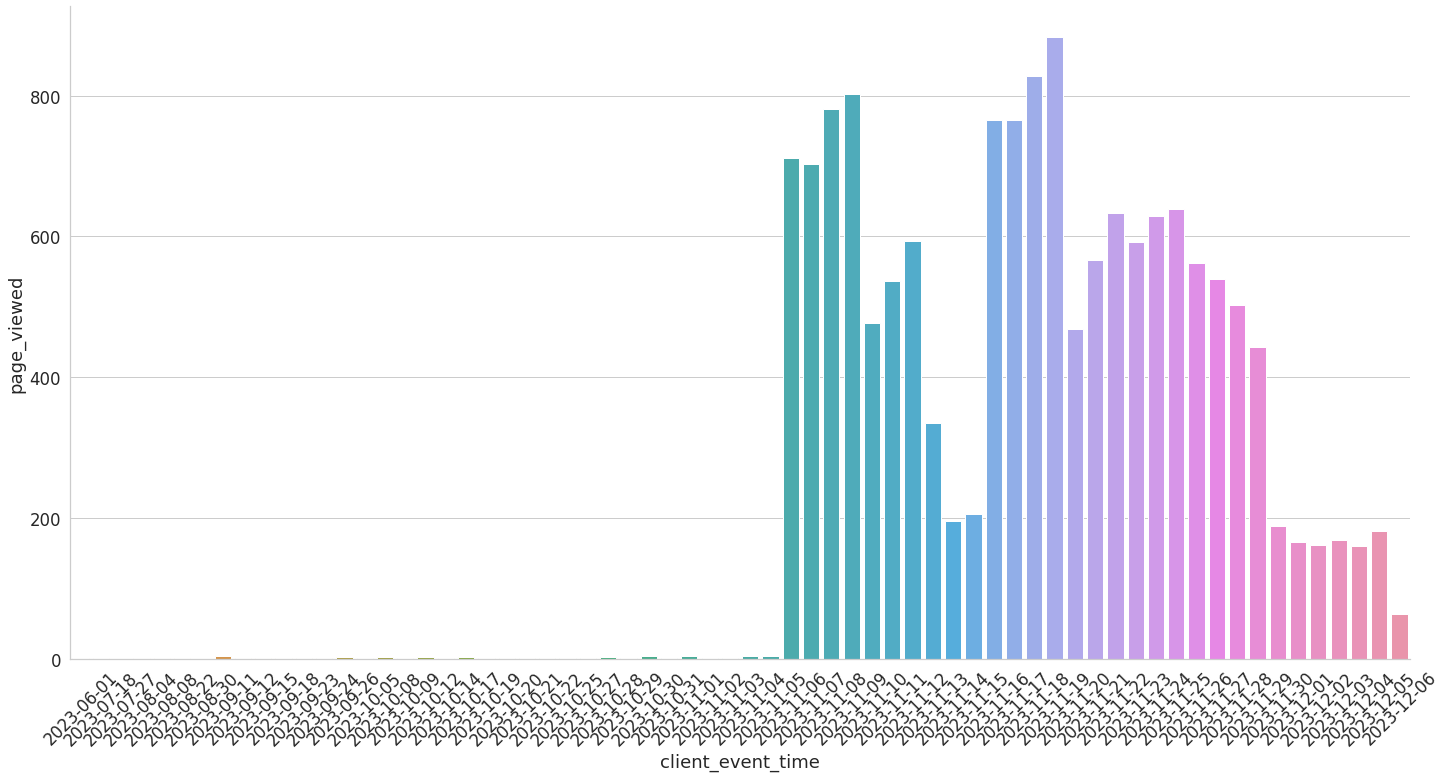

In [32]:
# Распределение уникальных посещений (девайсов) по дням:

sns.set(
    font_scale=1.5,
    style="whitegrid",
    rc={'figure.figsize':(24,12)}
        )

sns.barplot(data=events_pivot2, x="client_event_time", y="page_viewed", estimator=np.sum)
plt.xticks(rotation=45)
sns.despine()

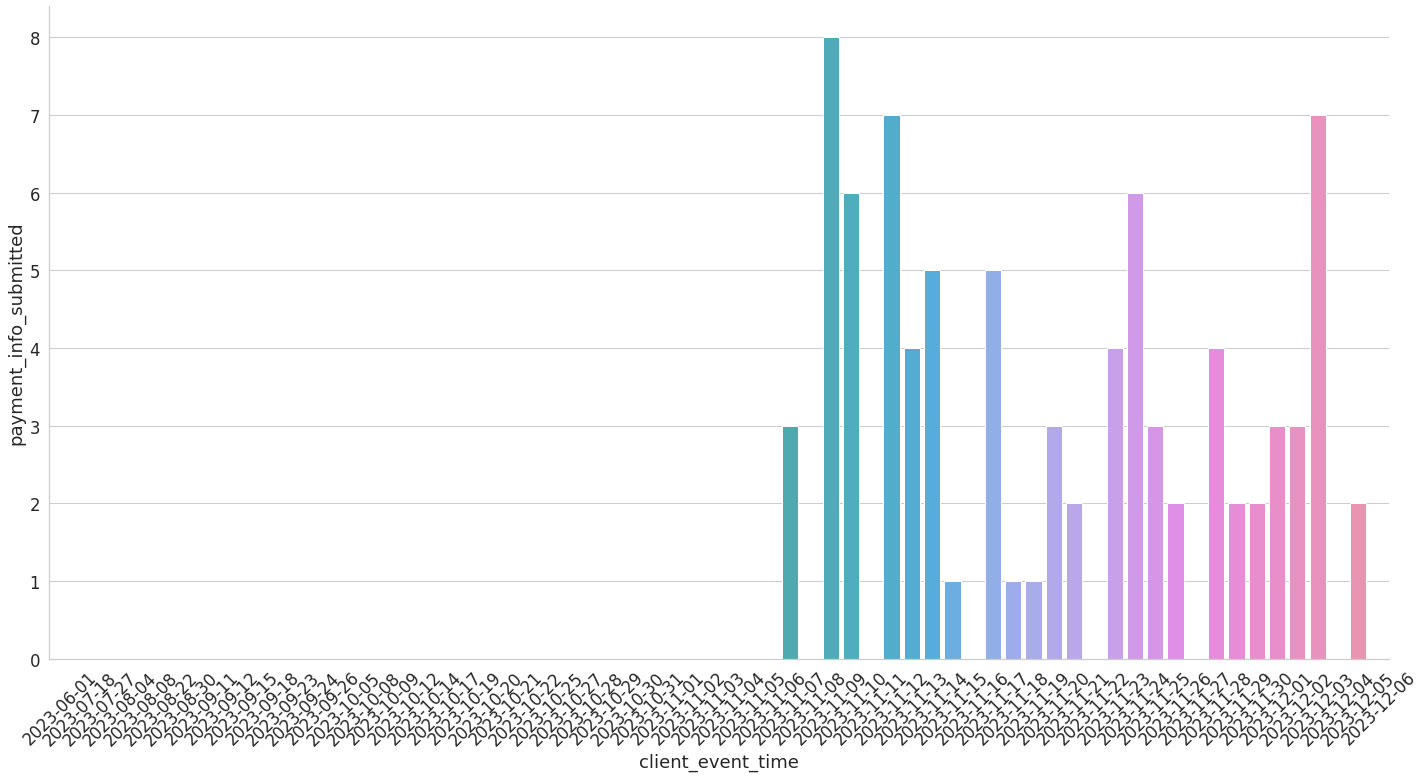

In [33]:
# Распределение конверсий от уникальных пользователей (девайсов) по дням:

sns.set(
    font_scale=1.5,
    style="whitegrid",
    rc={'figure.figsize':(24,12)}
        )

sns.barplot(data=events_pivot2, x="client_event_time", y="payment_info_submitted", estimator=np.sum)
plt.xticks(rotation=45)
sns.despine()

# Анализ трафика и конверсий

Ниже посчитаем сквозную конверсию из просмотра в заказ (точнее, в след. шаг после выбора метода оплаты) по дням:


In [34]:
CR_main = events_pivot2[["client_event_time", "page_viewed", "payment_info_submitted"]]
CR_main["CR"] = round((CR_main.payment_info_submitted / CR_main.page_viewed * 100), 2)


CR_main

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


event_type,client_event_time,page_viewed,payment_info_submitted,CR
index,,,,
0,2023-06-01,1.0,NaN,NaN
1,2023-07-18,1.0,NaN,NaN
2,2023-07-27,NaN,NaN,NaN
3,2023-08-04,1.0,NaN,NaN
4,2023-08-08,1.0,NaN,NaN
...,...,...,...,...
61,2023-12-02,161.0,3.0,1.86
62,2023-12-03,168.0,7.0,4.17
63,2023-12-04,160.0,NaN,NaN


In [35]:
# та же таблица, но без пустых значений по payment_info_submitted:

CR_main.query('payment_info_submitted != "NaN"')

event_type,client_event_time,page_viewed,payment_info_submitted,CR
index,,,,
36,2023-11-07,703.0,3.0,0.43
38,2023-11-09,803.0,8.0,1.00
39,2023-11-10,477.0,6.0,1.26
41,2023-11-12,593.0,7.0,1.18
42,2023-11-13,335.0,4.0,1.19
43,2023-11-14,195.0,5.0,2.56
44,2023-11-15,206.0,1.0,0.49
46,2023-11-17,766.0,5.0,0.65
47,2023-11-18,828.0,1.0,0.12


In [36]:
# Тотал-конверсия из page_viewed в payment_info_submitted:

total_conv = round((CR_main.payment_info_submitted.sum() / CR_main.page_viewed.sum() * 100), 2)

total_conv

0.55

In [37]:
# Конверсия по неделям:

CR_main['client_event_time'] = CR_main['client_event_time'].astype(str)
CR_main['client_event_time'] = pd.to_datetime(CR_main['client_event_time'])
CR_main['week'] = CR_main['client_event_time'] - pd.offsets.Week(weekday=0)

CR_main_by_week = CR_main.groupby('week', as_index = False).agg({'page_viewed': 'sum', 'payment_info_submitted': 'sum'})
CR_main_by_week["CR"] = round((CR_main_by_week.payment_info_submitted / CR_main_by_week.page_viewed * 100), 2)

CR_main_by_week

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

,week,page_viewed,payment_info_submitted,CR
0,2023-05-29,1.0,0.0,0.00
1,2023-07-17,1.0,0.0,0.00
2,2023-07-24,0.0,0.0,NaN
3,2023-07-31,1.0,0.0,0.00
4,2023-08-07,1.0,0.0,0.00
5,2023-08-21,1.0,0.0,0.00
6,2023-08-28,0.0,0.0,NaN
7,2023-09-04,3.0,0.0,0.00
8,2023-09-11,3.0,0.0,0.00
9,2023-09-18,2.0,0.0,0.00


In [38]:
# Конверсия только с недели 2023-10-30: 

round((CR_main_by_week.query('week > "2023-10-23"').payment_info_submitted.sum() / CR_main_by_week.query('week > "2023-10-23"').page_viewed.sum() * 100), 2)

0.55

**По конверсия weekly наблюдаем следующее:**  
вплоть до недели 2023-10-23 включительно было совсем мало событий просмотров страниц **уникальными пользователями**.  
Начиная с недели 2023-10-30	объем событий увеличился и стали появляться оформленные заказы.  
Далее в течение трех недель наблюдались пиковые значения по просмотрам (вероятно, запускалась реклама), затем (на неделе 
2023-11-27) пошли на спад.  
Одновременно со спадом просмотров повысилась конверсия в заказ.

**Стоит проверить влияние платных каналов на конверсию в эти временные промежутки.**  

Также по данным выше имеем в виду, что тотал-конверсия (сквозная) составляет 0.55%.   

Для провеки влияние платных каналов на конверсию из колонки user_properties вычленим source и medium:

In [39]:
df['utm_medium'] = df.user_properties.str.extract(r"(?<='initial_utm_medium':\s')([^']*)")

In [40]:
df['utm_source'] = df.user_properties.str.extract(r"(?<='initial_utm_source':\s')([^']*)")

Посмотрим на получившиеся уникальные значения source и medium:

In [41]:
df.utm_medium.unique()

array(['EMPTY', nan, 'Ads', 'vo', '23856534806730688', 'company_profile',
       '{{campaign.id}}', '120200983127270689', 'vo+140+-+Copy'],
      dtype=object)

In [42]:
df.utm_source.unique()

array(['EMPTY', nan, 'Facebook', 'OOAK+-+EUROPE+full+-+VIDEO',
       'Advantage++shopping+campaign+07/25/2023+Campaign', 'trustpilot',
       '{{campaign.name}}',
       'Advantage+ shopping campaign 07/25/2023 Campaign',
       'ASC++all+EU+-+all+aud+-+no+cap+07/25/2023-28/11/2023+Campaign',
       'ASC++all+EU+-+all+aud+-+no+cap+07%2F25%2F2023-28%2F11%2F2023+Campaign',
       'ASC  all EU - all aud - no cap 07/25/2023-28/11/2023 Campaign'],
      dtype=object)

In [43]:
# сгруппируем посещения по источнику и каналу:
df \
.groupby(['utm_source', 'utm_medium'], as_index = False) \
.agg({'device_id': 'nunique'}) \
.sort_values('device_id', ascending = False)

,utm_source,utm_medium,device_id
6,EMPTY,EMPTY,12469
7,Facebook,Ads,234
8,OOAK+-+EUROPE+full+-+VIDEO,vo,9
1,ASC++all+EU+-+all+aud+-+no+cap+07%2F25%2F2023-...,120200983127270689,7
9,trustpilot,company_profile,7
0,ASC all EU - all aud - no cap 07/25/2023-28/1...,120200983127270689,6
3,ASC++all+EU+-+all+aud+-+no+cap+07/25/2023-28/1...,120200983127270689,5
2,ASC++all+EU+-+all+aud+-+no+cap+07%2F25%2F2023-...,vo+140+-+Copy,3
10,{{campaign.name}},{{campaign.id}},3
5,Advantage++shopping+campaign+07/25/2023+Campaign,23856534806730688,2


Есть несколько битых значений по источнику и каналу, но в основном только Facebook и EMPTY (что, вероятно, значит, что источник не затрекался или это был переход по прямой ссылке).

При этом если посмотреть на другие метки с пустым источникок / каналом, видим, что присутствуют признаки перехода из facebook:

In [44]:
df.query('utm_medium == "EMPTY"').user_properties.unique().tolist()

["{'fbclid': 'IwAR295tUiGCljtUzVYpJ6BMKwmbhOsfWOZzqVdpE29BbIfD4KigCupWriGuo_aem_AZscUccOW47NMeS9RpcIrjMVd2SrITSWAKZyukg-o4f6YwRd8KoxYrFuzlZGElx3rVgGdpf4C_i_JcW8Eeha7VzI', 'initial_utm_medium': 'EMPTY', 'initial_referring_domain': 'm.facebook.com', 'initial_utm_content': 'EMPTY', 'initial_utm_campaign': 'EMPTY', 'initial_twclid': 'EMPTY', 'referrer': 'android-app://m.facebook.com/', 'initial_gclid': 'EMPTY', 'initial_utm_source': 'EMPTY', 'initial_dclid': 'EMPTY', 'initial_wbraid': 'EMPTY', 'initial_fbclid': 'IwAR295tUiGCljtUzVYpJ6BMKwmbhOsfWOZzqVdpE29BbIfD4KigCupWriGuo_aem_AZscUccOW47NMeS9RpcIrjMVd2SrITSWAKZyukg-o4f6YwRd8KoxYrFuzlZGElx3rVgGdpf4C_i_JcW8Eeha7VzI', 'initial_utm_id': 'EMPTY', 'initial_referrer': 'android-app://m.facebook.com/', 'initial_gbraid': 'EMPTY', 'initial_utm_term': 'EMPTY', 'initial_msclkid': 'EMPTY', 'initial_ttclid': 'EMPTY', 'initial_ko_click_id': 'EMPTY', 'referring_domain': 'm.facebook.com'}",
 "{'initial_utm_medium': 'EMPTY', 'initial_referring_domain': 'EMP

Подозрение вызывает метка 'referrer', посмотрим на нее поближе:

In [45]:
df['referrer'] = df.user_properties.str.extract(r"(?<='referrer':\s')([^']*)")

In [46]:
df \
.query('utm_medium == "EMPTY"') \
.groupby('referrer', as_index = False) \
.agg({'device_id': 'nunique'}) \
.sort_values('device_id', ascending = False) \
.head(15)

,referrer,device_id
6,http://instagram.com/,3785
16,https://l.instagram.com/,861
14,https://l.facebook.com/,813
8,http://m.facebook.com/,613
37,https://www.google.com/,453
18,https://lm.facebook.com/,171
50,https://www.instagram.com/,100
30,https://www.facebook.com/,39
56,https://yandex.ru/,32
12,https://kwork.ru/,30


**Все посещения с пустым значением по каналу были совершены по факту с источником - реферальная ссылка, и большинство - из ИГ и ФБ.**

Дособерем данные по ключевым меткам и взглянем еще раз на датасет:

In [47]:
df['utm_campaign'] = df.user_properties.str.extract(r"(?<='initial_utm_campaign':\s')([^']*)")

In [48]:
df.head()

,client_event_time,device_id,session_id,language,country,region,platform,os_name,device_type,device_family,event_type,event_properties,user_properties,utm_medium,utm_source,referrer,utm_campaign
0,2023-10-24 15:42:24.506,84bfeea2-f6ec-47c1-b9d0-791d1ac5c616,1698162134395,English,United States,North Carolina,Web,Chrome,-,K,session_end,{},{'fbclid': 'IwAR295tUiGCljtUzVYpJ6BMKwmbhOsfWO...,EMPTY,EMPTY,android-app://m.facebook.com/,EMPTY
1,2023-10-25 16:19:00.428,84bfeea2-f6ec-47c1-b9d0-791d1ac5c616,1698250740429,English,United States,North Carolina,Web,Chrome,-,K,session_start,{},{'fbclid': 'IwAR295tUiGCljtUzVYpJ6BMKwmbhOsfWO...,EMPTY,EMPTY,android-app://m.facebook.com/,EMPTY
2,2023-10-25 16:19:01.809,84bfeea2-f6ec-47c1-b9d0-791d1ac5c616,1698250740429,English,United States,North Carolina,Web,Chrome,-,K,[Amplitude] Page Viewed,{'[Amplitude] Page URL': 'https://example.com/...,{'fbclid': 'IwAR295tUiGCljtUzVYpJ6BMKwmbhOsfWO...,EMPTY,EMPTY,android-app://m.facebook.com/,EMPTY
3,2023-10-25 16:19:01.878,84bfeea2-f6ec-47c1-b9d0-791d1ac5c616,1698250740429,English,United States,North Carolina,Web,Chrome,-,K,Configurator start,"{'type': 'Hoodie', 'point.header': 'https://ex...",{'fbclid': 'IwAR295tUiGCljtUzVYpJ6BMKwmbhOsfWO...,EMPTY,EMPTY,android-app://m.facebook.com/,EMPTY
4,2023-10-25 16:19:01.880,84bfeea2-f6ec-47c1-b9d0-791d1ac5c616,1698250740429,English,United States,North Carolina,Web,Chrome,-,K,session_end,{},{'fbclid': 'IwAR295tUiGCljtUzVYpJ6BMKwmbhOsfWO...,EMPTY,EMPTY,android-app://m.facebook.com/,EMPTY


In [49]:
df \
.groupby('utm_campaign', as_index = False) \
.agg({'device_id': 'nunique'}) \
.sort_values('device_id', ascending = False) \
.head(10)

,utm_campaign,device_id
7,EMPTY,12479
2,ASC++all+EU+-+all+aud+-+no+cap+07/25/2023-28/1...,205
5,Advantage++shopping+campaign+07/25/2023+Campaign,20
1,ASC++all+EU+-+all+aud+-+no+cap+07%2F25%2F2023-...,10
0,ASC all EU - all aud - no cap 07/25/2023-28/1...,7
12,logo_click,5
6,Advantage++shopping+campaign+08/23/2023+Campaign,4
9,OOAK+ASC+best+countries+no+cap+140923,4
14,{{campaign.name}},3
8,OOAK+ASC+15+best+countries+-+all+ret+aud+-+no+...,2


В кампаниях также ничего интересного пока не нашлось, есть только небольшое кол-во НЕ-ноунеймов, основная масса - EMPTY.

In [50]:
# создадим новый дф для дальнейшего анализа конверсий по источникам:

tags = df[["client_event_time", "device_id", "session_id", "event_type", 'utm_source', 'utm_medium', 'utm_campaign', 'referrer']]
tags['client_event_time'] = tags['client_event_time'].dt.to_period("D")

# снова оставим в датасете только нужные события:
tags = tags.query("event_type.isin(@event_list)")

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [51]:
# добавляем начало недели:
tags['client_event_time'] = tags['client_event_time'].astype(str)
tags['client_event_time'] = pd.to_datetime(tags['client_event_time'])
tags['week'] = tags['client_event_time'] - pd.offsets.Week(weekday=0)

tags.head()

,client_event_time,device_id,session_id,event_type,utm_source,utm_medium,utm_campaign,referrer,week
2,2023-10-25,84bfeea2-f6ec-47c1-b9d0-791d1ac5c616,1698250740429,[Amplitude] Page Viewed,EMPTY,EMPTY,EMPTY,android-app://m.facebook.com/,2023-10-23
6,2023-11-06,84bfeea2-f6ec-47c1-b9d0-791d1ac5c616,1699228883465,[Amplitude] Page Viewed,EMPTY,EMPTY,EMPTY,android-app://m.facebook.com/,2023-10-30
18,2023-11-06,e83d5f52-d99c-4b41-abcc-f07d9d1a9a47,1699231051004,[Amplitude] Page Viewed,EMPTY,EMPTY,EMPTY,NaN,2023-10-30
28,2023-11-06,e83d5f52-d99c-4b41-abcc-f07d9d1a9a47,1699231051004,Work with the configurator,EMPTY,EMPTY,EMPTY,NaN,2023-10-30
29,2023-11-06,e83d5f52-d99c-4b41-abcc-f07d9d1a9a47,1699231051004,Work with the configurator,EMPTY,EMPTY,EMPTY,NaN,2023-10-30


In [52]:
# Сгруппируем посещения по неделям в разрезе меток:

views_by_tags = tags \
.query('event_type == "[Amplitude] Page Viewed"') \
.groupby(['week', 'utm_source', 'utm_medium', 'utm_campaign', 'referrer'], as_index = False) \
.agg({'device_id': 'count'})

views_by_tags.head()

,week,utm_source,utm_medium,utm_campaign,referrer,device_id
0,2023-07-17,EMPTY,EMPTY,EMPTY,http://instagram.com/,1
1,2023-07-31,EMPTY,EMPTY,EMPTY,https://www.google.com/,1
2,2023-08-07,EMPTY,EMPTY,EMPTY,http://instagram.com/,2
3,2023-08-21,Advantage++shopping+campaign+07/25/2023+Campaign,23856534806730688,Advantage++shopping+campaign+07/25/2023+Campaign,http://m.facebook.com/,1
4,2023-09-04,EMPTY,EMPTY,EMPTY,http://instagram.com/,1


In [53]:
views_by_tags.query('utm_medium == "EMPTY"').groupby('week', as_index = False).agg({'device_id': 'sum'})


,week,device_id
0,2023-07-17,1
1,2023-07-31,1
2,2023-08-07,2
3,2023-09-04,2
4,2023-09-11,3
5,2023-09-18,2
6,2023-09-25,2
7,2023-10-02,3
8,2023-10-09,3
9,2023-10-16,4


In [54]:
views_by_tags.query('utm_medium != "EMPTY"').groupby('week', as_index = False).agg({'device_id': 'sum'})


,week,device_id
0,2023-08-21,1
1,2023-10-30,6
2,2023-11-06,11
3,2023-11-13,8
4,2023-11-20,13
5,2023-11-27,123


**Посещения на неделе 2023-10-30 выросли за счет канала EMPTY. Далее посмотрим глубже в метки.**

In [55]:
# Сгруппируем покупки по неделям в разрезе меток:

purchases_by_tags = tags \
.query('event_type == "payment info submitted"') \
.groupby(['week', 'utm_source', 'utm_medium', 'utm_campaign', 'referrer'], as_index = False) \
.agg({'device_id': 'count'})

purchases_by_tags.head()

,week,utm_source,utm_medium,utm_campaign,referrer,device_id
0,2023-11-06,EMPTY,EMPTY,EMPTY,http://instagram.com/,1
1,2023-11-06,EMPTY,EMPTY,EMPTY,http://m.facebook.com/,1
2,2023-11-06,EMPTY,EMPTY,EMPTY,https://l.instagram.com/,2
3,2023-11-06,EMPTY,EMPTY,EMPTY,https://www.google.com/,2
4,2023-11-13,EMPTY,EMPTY,EMPTY,http://instagram.com/,3


In [56]:
# смерджим получившиеся таблицы по посещениям и покупкам:

views_and_purchases = views_by_tags \
.merge(purchases_by_tags, how = 'left', on = ['week', 'utm_source', 'utm_medium', 'utm_campaign', 'referrer']) \
.rename(columns = {'device_id_x': 'views', 'device_id_y': 'purchases'})

views_and_purchases.head()

,week,utm_source,utm_medium,utm_campaign,referrer,views,purchases
0,2023-07-17,EMPTY,EMPTY,EMPTY,http://instagram.com/,1,NaN
1,2023-07-31,EMPTY,EMPTY,EMPTY,https://www.google.com/,1,NaN
2,2023-08-07,EMPTY,EMPTY,EMPTY,http://instagram.com/,2,NaN
3,2023-08-21,Advantage++shopping+campaign+07/25/2023+Campaign,23856534806730688,Advantage++shopping+campaign+07/25/2023+Campaign,http://m.facebook.com/,1,NaN
4,2023-09-04,EMPTY,EMPTY,EMPTY,http://instagram.com/,1,NaN


In [57]:
# посмотрим на конверсии по referrer-ам c пустым источником:

y = views_and_purchases \
.query('utm_source == "EMPTY"') \
.groupby('referrer', as_index = False) \
.agg({'views': 'sum', 'purchases': 'sum'})

y["CR"] = round((y.purchases / y.views *100), 2)

# y.groupby('referrer', as_index = False) \
# .agg({'CR': 'mean'}).sort_values('CR', ascending = False)

y.sort_values('CR', ascending = False).head(10)

,referrer,views,purchases,CR
41,https://www.google.lt/,57,1.0,1.75
30,https://www.fl.ru/,87,1.0,1.15
36,https://www.google.com/,1672,11.0,0.66
16,https://l.instagram.com/,2211,6.0,0.27
8,http://m.facebook.com/,1179,2.0,0.17
6,http://instagram.com/,8663,7.0,0.08
0,android-app://com.google.android.gm/,18,0.0,0.00
32,https://www.google.ca/,1,0.0,0.00
33,https://www.google.ch/,24,0.0,0.00
34,https://www.google.co.in/,1,0.0,0.00


In [58]:
# и конкретно на те, где конверсия меньше средней:
    
y.query('CR < 0.55').sort_values('views', ascending = False).head(10)

,referrer,views,purchases,CR
6,http://instagram.com/,8663,7.0,0.08
16,https://l.instagram.com/,2211,6.0,0.27
14,https://l.facebook.com/,1618,0.0,0.00
8,http://m.facebook.com/,1179,2.0,0.17
18,https://lm.facebook.com/,357,0.0,0.00
49,https://www.instagram.com/,284,0.0,0.00
29,https://www.facebook.com/,62,0.0,0.00
37,https://www.google.de/,51,0.0,0.00
1,android-app://com.google.android.googlequickse...,50,0.0,0.00
12,https://kwork.ru/,50,0.0,0.00


**Наибольшее кол-во событий c пустым источником пришло из ИГ и ФБ.**

In [59]:
inst_fb = views_and_purchases[views_and_purchases['referrer'].str.contains('instagram|facebook')]
 
inst_fb.head()

,week,utm_source,utm_medium,utm_campaign,referrer,views,purchases
0,2023-07-17,EMPTY,EMPTY,EMPTY,http://instagram.com/,1,NaN
2,2023-08-07,EMPTY,EMPTY,EMPTY,http://instagram.com/,2,NaN
3,2023-08-21,Advantage++shopping+campaign+07/25/2023+Campaign,23856534806730688,Advantage++shopping+campaign+07/25/2023+Campaign,http://m.facebook.com/,1,NaN
4,2023-09-04,EMPTY,EMPTY,EMPTY,http://instagram.com/,1,NaN
5,2023-09-04,EMPTY,EMPTY,EMPTY,https://l.instagram.com/,1,NaN


In [60]:
# сгруппируем по кампаниям посетителей c referrer = instagram|facebook:

inst_fb.groupby('utm_campaign', as_index = False) \
.agg({'views': 'sum', 'purchases': 'sum'})

,utm_campaign,views,purchases
0,ASC all EU - all aud - no cap 07/25/2023-28/1...,5,0.0
1,ASC++all+EU+-+all+aud+-+no+cap+07%2F25%2F2023-...,15,0.0
2,ASC++all+EU+-+all+aud+-+no+cap+07/25/2023-28/1...,89,1.0
3,Advantage%2B+shopping+campaign+07%2F25%2F2023+...,2,0.0
4,Advantage++shopping+campaign+07/25/2023+Campaign,14,0.0
5,Advantage++shopping+campaign+08/23/2023+Campaign,7,0.0
6,EMPTY,14400,15.0
7,OOAK+ASC+best+countries+no+cap+140923,7,0.0
8,logo_click,1,0.0
9,tshirt-shorts,7,0.0


**Получается, из трафика, который остался не промеченным utm-метками и который пришел из фб и иг, бОльшая часть кампаний - действительно НЕ-рекламный трафик (utm_campaign = EMPTY).**   

**Видимо, этот трафик приходит органически из соцсетей магазина (на которые в свою очередь, вероятно, по какой-то причине пришло одновременно много трафика, может, реклама у блогеров),  
ЛИБО по ошибке запустили рекламу в фб и иг без utm-меток, а ЦА оказалась нецелевой / фродовой, заходили на сайт, но не покупали.**

В таблице с конверсиями по дням выше также можно было заметить, что CR была наиболее низкой в период с 2023-11-15 по 2023-11-29, визуализирую для наглядности:


In [61]:
f = CR_main[['client_event_time', 'CR']]

f.client_event_time = f.client_event_time.dt.strftime('%d-%m-%Y')

f

/opt/tljh/user/lib/python3.7/site-packages/pandas/core/generic.py:5165: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


event_type,client_event_time,CR
index,,
0,01-06-2023,NaN
1,18-07-2023,NaN
2,27-07-2023,NaN
3,04-08-2023,NaN
4,08-08-2023,NaN
...,...,...
61,02-12-2023,1.86
62,03-12-2023,4.17
63,04-12-2023,NaN


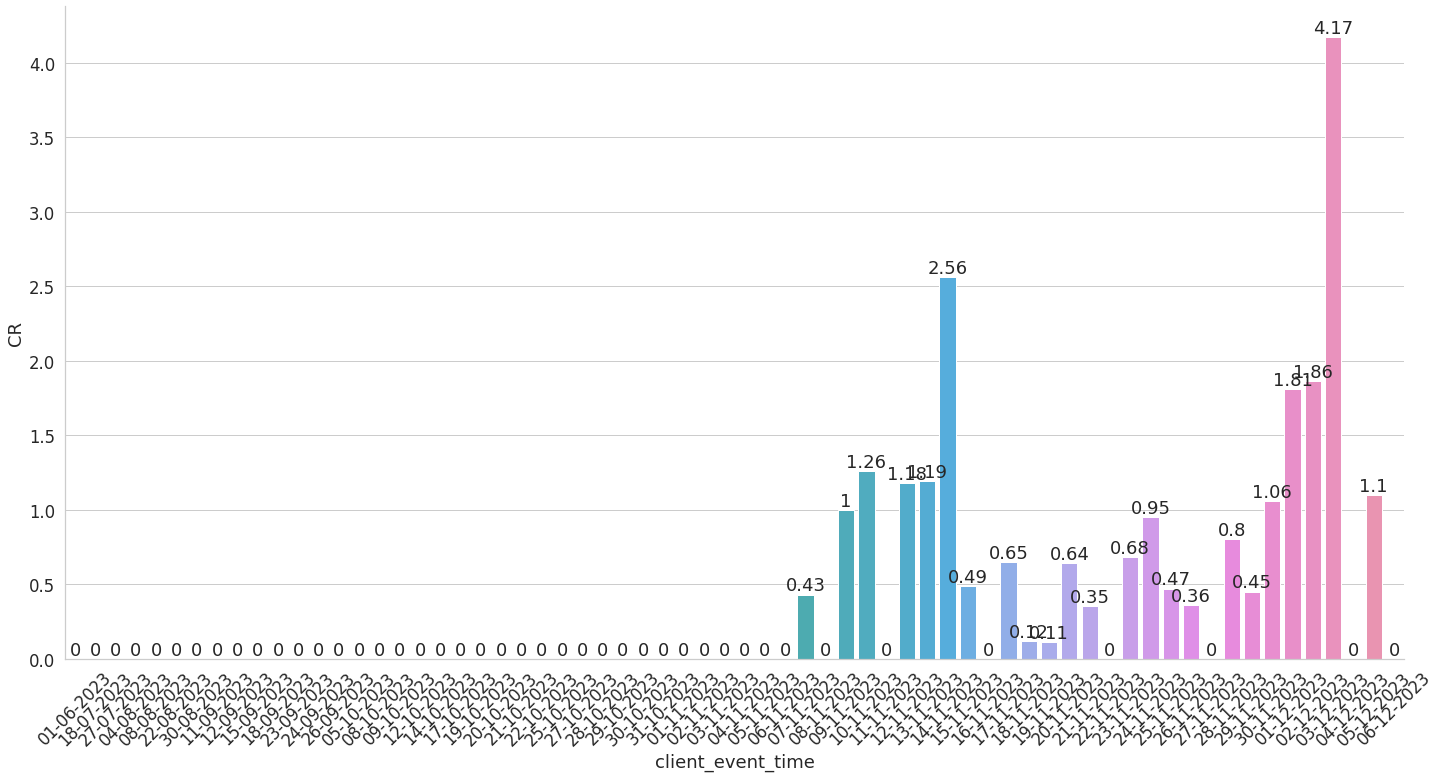

In [62]:
sns.set(
    font_scale=1.5,
    style="whitegrid",
    rc={'figure.figsize':(24,12)}
        )


ax = sns.barplot(data=f, x='client_event_time', y="CR", estimator=np.sum)
ax.bar_label(ax.containers[0])
plt.xticks(rotation=45)
sns.despine()
plt.show()

Посмотрим на метки в период с 2023-11-15 по 2023-11-29:


In [63]:
a = tags
b = a \
.query('event_type == "[Amplitude] Page Viewed"') \
.groupby(['client_event_time', 'utm_source', 'utm_medium', 'utm_campaign', 'referrer'], as_index = False) \
.agg({'device_id': 'count'})
c = a \
.query('event_type == "payment info submitted"') \
.groupby(['client_event_time', 'utm_source', 'utm_medium', 'utm_campaign', 'referrer'], as_index = False) \
.agg({'device_id': 'count'})

views_and_purchases_by_day = b \
.merge(c, how = 'left', on = ['client_event_time', 'utm_source', 'utm_medium', 'utm_campaign', 'referrer']) \
.rename(columns = {'device_id_x': 'views', 'device_id_y': 'purchases'})

views_and_purchases_by_day


# Задаем интервалы дат: до 'подозрительного' периода, во время и после:

views_and_purchases_by_day["period"] = pd \
.cut(views_and_purchases_by_day.client_event_time, pd.to_datetime(['2023-05-08', '2023-11-14', '2023-11-29', '2023-12-07']), 
     labels = ['before 2023-11-25', 'between 2023-11-25 and 2023-11-29', 'after 2023-11-29'])


In [64]:
views_and_purchases_by_day.head()

,client_event_time,utm_source,utm_medium,utm_campaign,referrer,views,purchases,period
0,2023-07-18,EMPTY,EMPTY,EMPTY,http://instagram.com/,1,NaN,before 2023-11-25
1,2023-08-04,EMPTY,EMPTY,EMPTY,https://www.google.com/,1,NaN,before 2023-11-25
2,2023-08-08,EMPTY,EMPTY,EMPTY,http://instagram.com/,2,NaN,before 2023-11-25
3,2023-08-22,Advantage++shopping+campaign+07/25/2023+Campaign,23856534806730688,Advantage++shopping+campaign+07/25/2023+Campaign,http://m.facebook.com/,1,NaN,before 2023-11-25
4,2023-09-11,EMPTY,EMPTY,EMPTY,http://instagram.com/,1,NaN,before 2023-11-25


In [65]:
views_and_purchases_by_day = views_and_purchases_by_day.astype({'period': 'string'})

u = views_and_purchases_by_day \
.groupby(['period', 'utm_source', 'referrer'], as_index = False) \
.agg({'views': 'sum', 'purchases': 'sum'})

In [66]:
u.head()

,period,utm_source,referrer,views,purchases
0,after 2023-11-29,EMPTY,android-app://com.google.android.gm/,1,0.0
1,after 2023-11-29,EMPTY,android-app://com.google.android.googlequickse...,5,0.0
2,after 2023-11-29,EMPTY,android-app://m.facebook.com/,2,0.0
3,after 2023-11-29,EMPTY,http://instagram.com/,335,0.0
4,after 2023-11-29,EMPTY,http://m.facebook.com/,70,0.0


In [67]:
u.pivot_table('views', index = 'utm_source', columns = 'period', aggfunc = 'sum').fillna("-")



period,after 2023-11-29,before 2023-11-25,between 2023-11-25 and 2023-11-29
utm_source,,,
ASC all EU - all aud - no cap 07/25/2023-28/11/2023 Campaign,-,-,5
ASC++all+EU+-+all+aud+-+no+cap+07%2F25%2F2023-28%2F11%2F2023+Campaign,-,-,14
ASC++all+EU+-+all+aud+-+no+cap+07/25/2023-28/11/2023+Campaign,-,-,12
Advantage+ shopping campaign 07/25/2023 Campaign,-,-,7
Advantage++shopping+campaign+07/25/2023+Campaign,-,7,-
EMPTY,1038,6277,9316
Facebook,-,8,96
trustpilot,-,-,1
{{campaign.name}},-,3,9


**Видим, что в период просадки конверсии прибавилось посещений именно по EMPTY-источнику,**

In [68]:
u.pivot_table('views', index = 'referrer', columns = 'period', aggfunc = 'sum').fillna("-")


period,after 2023-11-29,before 2023-11-25,between 2023-11-25 and 2023-11-29
referrer,,,
android-app://com.google.android.gm/,1,15,2
android-app://com.google.android.googlequicksearchbox/,5,20,25
android-app://com.pinterest/,-,2,-
android-app://m.facebook.com/,2,3,3
android-app://org.telegram.messenger/,-,5,-
http://baidu.com/,-,-,4
http://instagram.com/,335,3082,5299
http://m.facebook.com,-,1,15
http://m.facebook.com/,70,654,483


**и по двум referrer-ам: http://instagram.com/ и https://l.instagram.com/ (последнее - десктопные переходы)**

Проанализируем также промежуточные конверсии из шага в шаг:

In [69]:
# добавляю в сводную таблицу промежуточные конверсии:

events_pivot2['CR1'] = round((events_pivot2.work_with_the_configurator / events_pivot2.page_viewed * 100), 0)
events_pivot2['CR2'] = round((events_pivot2.product_add / events_pivot2.work_with_the_configurator * 100), 0)
events_pivot2['CR3'] = round((events_pivot2.order_view / events_pivot2.product_add * 100), 0)
events_pivot2['CR4'] = round((events_pivot2.personal_info_submitted / events_pivot2.order_view * 100), 0)
events_pivot2['CR5'] = round((events_pivot2.shipping_info_submitted / events_pivot2.personal_info_submitted * 100), 0)
events_pivot2['CR6'] = round((events_pivot2.payment_info_submitted / events_pivot2.shipping_info_submitted * 100), 0)

In [70]:
events_pivot3 = events_pivot2[['client_event_time', 'page_viewed', 'CR1', 'work_with_the_configurator', 'CR2', 'product_add', 'CR3', 'order_view', 'CR4', 'personal_info_submitted', 'CR5', 'shipping_info_submitted', 'CR6', 'payment_info_submitted']].fillna(0)


events_pivot3.head()

event_type,client_event_time,page_viewed,CR1,work_with_the_configurator,CR2,product_add,CR3,order_view,CR4,personal_info_submitted,CR5,shipping_info_submitted,CR6,payment_info_submitted
index,,,,,,,,,,,,,,
0,2023-06-01,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2023-07-18,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2023-07-27,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2023-08-04,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2023-08-08,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Посмотрим на средние значения промежуточных конверсий по периодам: до 2023-11-15, во время спада конверсии (2023-11-15 - 2023-11-29) и после 2023-11-29:**

In [71]:
# отсекаем в том числе все даты до 2023-11-06, т.к. событий там почти нет 

a = events_pivot3.query('client_event_time < "2023-11-15" and client_event_time > "2023-11-05"').mean().round().to_frame().reset_index().rename(columns = {0: 'before 2023-11-15 mean'})
b = events_pivot3.query('client_event_time > "2023-11-14" and client_event_time < "2023-11-30"').mean().round().to_frame().rename(columns = {0: "2023-11-15 - 2023-11-29 mean"})
c = events_pivot3.query('client_event_time > "2023-11-29"').mean().round().to_frame().rename(columns = {0: "after 2023-11-29 mean"})

In [72]:
mean_conv = a.merge(b, on = 'event_type').merge(c, on = 'event_type')

mean_conv

,event_type,before 2023-11-15 mean,2023-11-15 - 2023-11-29 mean,after 2023-11-29 mean
0,page_viewed,570.0,602.0,155.0
1,CR1,50.0,42.0,39.0
2,work_with_the_configurator,291.0,243.0,60.0
3,CR2,22.0,20.0,24.0
4,product_add,65.0,48.0,15.0
5,CR3,100.0,100.0,100.0
6,order_view,65.0,48.0,15.0
7,CR4,15.0,13.0,29.0
8,personal_info_submitted,8.0,6.0,5.0
9,CR5,83.0,84.0,62.0


В период общего спада сквозной конверсии  
совсем аномальных изменений по промежуточным конверсиям не заметно. (но в 3й период сильно выросла cr4 -  из order_view в посещение страницы заполнения перс. данных).

При этом видим, что довольно низкая конверсия в заполнение персональных данных (CR5) - вероятно, форма сложная или же есть баги/неудобства на странице.

100% конверсия из product_add в просмотр заказа говорит о том, что вероятно, сразу туда перекидывает после добавления товара в корзину, что неудобно с т.ч. пользователя.

Но выше мы смотрим только на часть событий, которые отобрали в начале.
Попробуем посмотреть и другие события, которые совершали юзеры, у которых не было покупок.

In [73]:
df.head()

,client_event_time,device_id,session_id,language,country,region,platform,os_name,device_type,device_family,event_type,event_properties,user_properties,utm_medium,utm_source,referrer,utm_campaign
0,2023-10-24 15:42:24.506,84bfeea2-f6ec-47c1-b9d0-791d1ac5c616,1698162134395,English,United States,North Carolina,Web,Chrome,-,K,session_end,{},{'fbclid': 'IwAR295tUiGCljtUzVYpJ6BMKwmbhOsfWO...,EMPTY,EMPTY,android-app://m.facebook.com/,EMPTY
1,2023-10-25 16:19:00.428,84bfeea2-f6ec-47c1-b9d0-791d1ac5c616,1698250740429,English,United States,North Carolina,Web,Chrome,-,K,session_start,{},{'fbclid': 'IwAR295tUiGCljtUzVYpJ6BMKwmbhOsfWO...,EMPTY,EMPTY,android-app://m.facebook.com/,EMPTY
2,2023-10-25 16:19:01.809,84bfeea2-f6ec-47c1-b9d0-791d1ac5c616,1698250740429,English,United States,North Carolina,Web,Chrome,-,K,[Amplitude] Page Viewed,{'[Amplitude] Page URL': 'https://example.com/...,{'fbclid': 'IwAR295tUiGCljtUzVYpJ6BMKwmbhOsfWO...,EMPTY,EMPTY,android-app://m.facebook.com/,EMPTY
3,2023-10-25 16:19:01.878,84bfeea2-f6ec-47c1-b9d0-791d1ac5c616,1698250740429,English,United States,North Carolina,Web,Chrome,-,K,Configurator start,"{'type': 'Hoodie', 'point.header': 'https://ex...",{'fbclid': 'IwAR295tUiGCljtUzVYpJ6BMKwmbhOsfWO...,EMPTY,EMPTY,android-app://m.facebook.com/,EMPTY
4,2023-10-25 16:19:01.880,84bfeea2-f6ec-47c1-b9d0-791d1ac5c616,1698250740429,English,United States,North Carolina,Web,Chrome,-,K,session_end,{},{'fbclid': 'IwAR295tUiGCljtUzVYpJ6BMKwmbhOsfWO...,EMPTY,EMPTY,android-app://m.facebook.com/,EMPTY


In [74]:
# создаем список тех, кто совершал покупки:

users_with_purchases = events.query('event_type == "payment info submitted"').device_id.unique().tolist()

In [75]:
# Группируем всех остальных по событиям:

df \
.query('device_id not in @users_with_purchases') \
.groupby('event_type', as_index = False) \
.agg({'device_id': 'count'}) \
.sort_values('device_id', ascending = False) \
.rename(columns = {'device_id': 'count'})

,event_type,count
12,Work with the configurator,543078
1,Configurator start,150820
14,[Amplitude] Page Viewed,30634
33,session_start,16185
8,Next button clicked,6348
9,Random button clicked,4900
32,session_end,3826
16,basket config pressed,2337
28,product add,2191
23,order view,2191


**По количеству событий из списка выше нельзя сказать, что много пользователей, не совершивших покупку, уходили куда-то в FAQ или в форму обратной связи, скорее - зависали на конфигураторе (как я понимаю, это фильтры онлайн-магазина).   
Вероятно, там тоже могли быть какие-то шероховатости по UX/UI.**

Посмотрим еще на URL-ы в разным разрезах:


In [76]:
df['url'] = df.event_properties.transform(eval).str['[Amplitude] Page URL']

df.head()

,client_event_time,device_id,session_id,language,country,region,platform,os_name,device_type,device_family,event_type,event_properties,user_properties,utm_medium,utm_source,referrer,utm_campaign,url
0,2023-10-24 15:42:24.506,84bfeea2-f6ec-47c1-b9d0-791d1ac5c616,1698162134395,English,United States,North Carolina,Web,Chrome,-,K,session_end,{},{'fbclid': 'IwAR295tUiGCljtUzVYpJ6BMKwmbhOsfWO...,EMPTY,EMPTY,android-app://m.facebook.com/,EMPTY,None
1,2023-10-25 16:19:00.428,84bfeea2-f6ec-47c1-b9d0-791d1ac5c616,1698250740429,English,United States,North Carolina,Web,Chrome,-,K,session_start,{},{'fbclid': 'IwAR295tUiGCljtUzVYpJ6BMKwmbhOsfWO...,EMPTY,EMPTY,android-app://m.facebook.com/,EMPTY,None
2,2023-10-25 16:19:01.809,84bfeea2-f6ec-47c1-b9d0-791d1ac5c616,1698250740429,English,United States,North Carolina,Web,Chrome,-,K,[Amplitude] Page Viewed,{'[Amplitude] Page URL': 'https://example.com/...,{'fbclid': 'IwAR295tUiGCljtUzVYpJ6BMKwmbhOsfWO...,EMPTY,EMPTY,android-app://m.facebook.com/,EMPTY,https://example.com/us/ooak-man-hoodie-configu...
3,2023-10-25 16:19:01.878,84bfeea2-f6ec-47c1-b9d0-791d1ac5c616,1698250740429,English,United States,North Carolina,Web,Chrome,-,K,Configurator start,"{'type': 'Hoodie', 'point.header': 'https://ex...",{'fbclid': 'IwAR295tUiGCljtUzVYpJ6BMKwmbhOsfWO...,EMPTY,EMPTY,android-app://m.facebook.com/,EMPTY,None
4,2023-10-25 16:19:01.880,84bfeea2-f6ec-47c1-b9d0-791d1ac5c616,1698250740429,English,United States,North Carolina,Web,Chrome,-,K,session_end,{},{'fbclid': 'IwAR295tUiGCljtUzVYpJ6BMKwmbhOsfWO...,EMPTY,EMPTY,android-app://m.facebook.com/,EMPTY,None


In [77]:
# Общая группировка по уникальным посещениям:

df \
.query('device_id not in @users_with_purchases') \
.groupby('url', as_index = False) \
.agg({'device_id': 'nunique'}) \
.sort_values('device_id', ascending = False) \
.head(15)

,url,device_id
2,https://example.com/,10743
91,https://example.com/ooak-woman-hoodie-configur...,4780
40,https://example.com/ooak-man-hoodie-configurator,1818
125,https://example.com/ooak-woman-pants-configurator,1380
177,https://example.com/us,934
156,https://example.com/ooak-woman-tshirt-configur...,713
61,https://example.com/ooak-man-pants-configurator,476
143,https://example.com/ooak-woman-shorts-configur...,470
219,https://example.com/us/ooak-woman-hoodie-confi...,447
30,https://example.com/cart,422


**Какие страницы посещали юзеры, которые не совершили покупки:**


In [78]:
pd.set_option('max_colwidth', 120)
pd.set_option('display.width', 500)

urls1 = df \
.query('device_id not in @users_with_purchases') \
.groupby('device_id')['url'].apply(list) \
.reset_index() \

urls1.url = urls1.url.apply(str)

urls1

,device_id,url
0,0000e9c0-318d-42c9-a2d1-ede6f2374c95,"[None, 'https://example.com/ooak-woman-hoodie-configurator', None, None, None, None, None, None, None, None, None]"
1,0001bb05-160f-46fb-b186-6a3d6cf5d78c,"[None, 'https://example.com/']"
2,00071137-b641-4622-bfba-4cf14af5abf8,"[None, 'https://example.com/']"
3,00079a3f-b968-423f-8bae-7cdd00dd18cd,"[None, None, 'https://example.com/', 'https://example.com/ooak-woman-pants-configurator', None, None, None, None, No..."
4,000b0a92-1ba7-4dac-af50-b3efc9f3e367,"[None, 'https://example.com/']"
...,...,...
13425,ffdd1f41-59d4-45bf-adf9-24e53b7fb9f3,"[None, 'https://example.com/', 'https://example.com/ooak-woman-shorts-configurator', 'https://example.com/ooak-woman..."
13426,fff05821-2a00-48c9-8b13-5154d3ab3d3e,"[None, 'https://example.com/']"
13427,fff1257c-7416-43b3-aa5f-1abb73270073,"[None, 'https://example.com/', None, 'https://example.com/ooak-woman-hoodie-configurator', None, None, None, None, N..."
13428,fff31d68-6294-4c52-8564-ee1dd8344f38,"[None, None, 'https://example.com/', 'https://example.com/ooak-woman-pants-configurator', None, None, None, None, No..."


**Какие страницы посещали юзеры, у которых были покупки:**


In [79]:
pd.set_option('max_colwidth', 120)
pd.set_option('display.width', 500)

urls2 = df \
.query('device_id in @users_with_purchases') \
.groupby('device_id')['url'].apply(list) \
.reset_index() \

urls2.url = urls2.url.apply(str)

urls2

,device_id,url
0,05dc3b32-f511-483e-b210-2b9a340a1a53,"[None, 'https://example.com/', None, 'https://example.com/us', 'https://example.com/us/ooak-woman-hoodie-configurato..."
1,07084d50-b2fa-421d-95ea-c8ac738e29af,"[None, 'https://example.com/', 'https://example.com/ooak-man-hoodie-configurator', None, None, None, None, None, Non..."
2,0c7e6c40-7c3c-48a0-a228-ab009ffbb929,"[None, 'https://example.com/', 'https://example.com/ooak-woman-hoodie-configurator', None, None, None, None, None, N..."
3,0d541426-c958-43de-b022-f6280fb6908a,"[None, None, 'https://example.com/', 'https://example.com/ooak-woman-pants-configurator', None, None, None, None, No..."
4,150d6345-10cc-4043-9e2d-6a8f1c2615b2,"[None, 'https://example.com/', 'https://example.com/ooak-woman-hoodie-configurator', None, None, None, None, None, N..."
...,...,...
76,f1c5dfb3-94a4-42b5-925f-c099d025e059,"[None, 'https://example.com/', None, 'https://example.com/us', 'https://example.com/us/ooak-woman-hoodie-configurato..."
77,f2c14c52-cf5e-4ffb-93f4-873b28cc99d4,"[None, 'https://example.com/', None, 'https://example.com/us', 'https://example.com/us/ooak-woman-hoodie-configurato..."
78,fc14cdb4-fba3-4a9d-b19d-35e0f7c7fe5c,"[None, 'https://example.com/#rec583047797', 'https://example.com/ooak-woman-pants-configurator', None, None, None, N..."
79,fe6bbbdb-4fe2-40be-bcc6-0446f6061534,"[None, 'https://example.com/us/ooak-woman-tshirt-configurator#', None, None, None, None, 'https://example.com/us/ooa..."


In [80]:
# Частота встречаемости урлов в посещениях у группы НЕ-покупателей:


res1 = urls1['url'].apply(lambda x:ast.literal_eval(x)).explode().value_counts(dropna=False)
res1 = res1.to_frame()
res1["percent"] = round(res1.url / res1.url.sum() * 100, 0)

res1

,url,percent
NaN,736248,96.0
https://example.com/,13249,2.0
https://example.com/ooak-woman-hoodie-configurator,5585,1.0
https://example.com/ooak-man-hoodie-configurator,2041,0.0
https://example.com/ooak-woman-pants-configurator,1513,0.0
...,...,...
https://example.com/ooak-woman-shorts-configurator#incision,1,0.0
https://example.com/ooak-woman-hoodie-configurator#create#!/tab/583030177-2,1,0.0
https://example.com/#next,1,0.0
https://example.com/cart#faq,1,0.0


In [81]:
# Частота встречаемости урлов в посещениях у группы покупателей:

res2 = urls2['url'].apply(lambda x:ast.literal_eval(x)).explode().value_counts(dropna=False)
res2 = res2.to_frame()
res2["percent"] = round(res2.url / res2.url.sum() * 100, 0)

res2

,url,percent
NaN,17543,95.0
https://example.com/,124,1.0
https://example.com/cart,114,1.0
https://example.com/thank-you,95,1.0
https://example.com/ooak-woman-hoodie-configurator,83,0.0
...,...,...
https://example.com/ooak-woman-hoodie-configurator#pocket,1,0.0
https://example.com/us/ooak-woman-tshirt-configurator#size,1,0.0
https://example.com/ooak-man-hoodie-configurator#hood,1,0.0
https://example.com/#about,1,0.0


**Более 95% всех страниц - пустые.   
Видимо, некорректно трекаются посещенные страницы и в том числе из-за этого могут перетираться utm-метки.**

Но отметим, что у группы не-покупателей на 2-3 местах после стартовой страницы - конвигураторы по худи. 
Возможно, конкретно там есть на что обратить внимание с точки зрения UX/UI.

**Какие страницы посещали юзеры, у которых пустые utm-метки:**

In [82]:
pd.set_option('max_colwidth', 120)
pd.set_option('display.width', 500)

urls3 = df \
.query('utm_medium == "EMPTY"') \
.groupby('device_id')['url'].apply(list) \
.reset_index() \

urls3.url = urls3.url.apply(str)


urls3

,device_id,url
0,0000e9c0-318d-42c9-a2d1-ede6f2374c95,"['https://example.com/ooak-woman-hoodie-configurator', None, None, None, None, None, None, None, None, None]"
1,0001bb05-160f-46fb-b186-6a3d6cf5d78c,['https://example.com/']
2,00071137-b641-4622-bfba-4cf14af5abf8,['https://example.com/']
3,00079a3f-b968-423f-8bae-7cdd00dd18cd,"[None, None, 'https://example.com/', 'https://example.com/ooak-woman-pants-configurator', None, None, None, None, No..."
4,000b0a92-1ba7-4dac-af50-b3efc9f3e367,['https://example.com/']
...,...,...
12464,ffdd1f41-59d4-45bf-adf9-24e53b7fb9f3,"['https://example.com/', 'https://example.com/ooak-woman-shorts-configurator', 'https://example.com/ooak-woman-hoodi..."
12465,fff05821-2a00-48c9-8b13-5154d3ab3d3e,['https://example.com/']
12466,fff1257c-7416-43b3-aa5f-1abb73270073,"['https://example.com/', None, 'https://example.com/ooak-woman-hoodie-configurator', None, None, None, None, None, N..."
12467,fff31d68-6294-4c52-8564-ee1dd8344f38,"[None, None, 'https://example.com/', 'https://example.com/ooak-woman-pants-configurator', None, None, None, None, No..."


**Какие страницы посещали юзеры, у которых НЕ-пустые utm-метки:**

In [83]:
pd.set_option('max_colwidth', 120)
pd.set_option('display.width', 500)

urls4 = df \
.query('utm_medium != "EMPTY"') \
.groupby('device_id')['url'].apply(list) \
.reset_index() \

urls4.url = urls4.url.apply(str)


urls4

,device_id,url
0,0000e9c0-318d-42c9-a2d1-ede6f2374c95,[None]
1,0001bb05-160f-46fb-b186-6a3d6cf5d78c,[None]
2,00071137-b641-4622-bfba-4cf14af5abf8,[None]
3,000b0a92-1ba7-4dac-af50-b3efc9f3e367,[None]
4,000b2300-fe7a-4a39-9ef4-fb6fdc2f7e25,[None]
...,...,...
12601,ffd7ad0f-a1d1-44d6-b9ab-40614c60eb88,[None]
12602,ffdd1f41-59d4-45bf-adf9-24e53b7fb9f3,[None]
12603,fff05821-2a00-48c9-8b13-5154d3ab3d3e,[None]
12604,fff1257c-7416-43b3-aa5f-1abb73270073,[None]


In [84]:
# Частота встречаемости урлов в посещениях у группы c пустыми utm-метками:


res3 = urls3['url'].apply(lambda x:ast.literal_eval(x)).explode().value_counts(dropna=False)
res3 = res3.to_frame()
res3["percent"] = round(res3.url / res3.url.sum() * 100, 0)

res3 = res3.reset_index().fillna('-')

res3

,index,url,percent
0,-,688090,96.0
1,https://example.com/,13077,2.0
2,https://example.com/ooak-woman-hoodie-configurator,5147,1.0
3,https://example.com/ooak-man-hoodie-configurator,1910,0.0
4,https://example.com/ooak-woman-pants-configurator,1452,0.0
...,...,...,...
265,https://example.com/us/ooak-woman-hoodie-configurator#length#!/tab/637395515-2,1,0.0
266,https://www.example.com/cart,1,0.0
267,https://example.com/us/ooak-man-hoodie-configurator#faq,1,0.0
268,https://example.com/us/ooak-woman-shorts-configurator#,1,0.0


In [85]:
# Частота встречаемости урлов в посещениях у группы c НЕ-пустыми utm-метками:


res4 = urls4['url'].apply(lambda x:ast.literal_eval(x)).explode().value_counts(dropna=False)
res4 = res4.to_frame()
res4["percent"] = round(res4.url / res4.url.sum() * 100, 0)

res4 = res4.reset_index().fillna('-')

res4

,index,url,percent
0,-,65701,97.0
1,https://example.com/ooak-woman-hoodie-configurator,521,1.0
2,https://example.com/,296,0.0
3,https://example.com/ooak-man-hoodie-configurator,169,0.0
4,https://example.com/us,117,0.0
...,...,...,...
107,https://example.com/us/ooak-man-pants-configurator#growth,1,0.0
108,https://example.com/de,1,0.0
109,https://example.com/ooak-woman-pants-configurator#color,1,0.0
110,https://example.com/us/ooak-man-hoodie-configurator#cut,1,0.0


Уберем из последних двух таблиц нулевые урлы:

In [86]:
res3_no_nan = res3.query('index != "-"')
res3_no_nan["percent"] = round(res3_no_nan.url / res3_no_nan.url.sum() * 100, 0)

res3_no_nan

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,index,url,percent
1,https://example.com/,13077,44.0
2,https://example.com/ooak-woman-hoodie-configurator,5147,17.0
3,https://example.com/ooak-man-hoodie-configurator,1910,6.0
4,https://example.com/ooak-woman-pants-configurator,1452,5.0
5,https://example.com/us,1066,4.0
...,...,...,...
265,https://example.com/us/ooak-woman-hoodie-configurator#length#!/tab/637395515-2,1,0.0
266,https://www.example.com/cart,1,0.0
267,https://example.com/us/ooak-man-hoodie-configurator#faq,1,0.0
268,https://example.com/us/ooak-woman-shorts-configurator#,1,0.0


In [87]:
res4_no_nan = res4.query('index != "-"')
res4_no_nan["percent"] = round(res4_no_nan.url / res4_no_nan.url.sum() * 100, 0)

res4_no_nan

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,index,url,percent
1,https://example.com/ooak-woman-hoodie-configurator,521,25.0
2,https://example.com/,296,14.0
3,https://example.com/ooak-man-hoodie-configurator,169,8.0
4,https://example.com/us,117,6.0
5,https://example.com/us/ooak-woman-hoodie-configurator,114,6.0
...,...,...,...
107,https://example.com/us/ooak-man-pants-configurator#growth,1,0.0
108,https://example.com/de,1,0.0
109,https://example.com/ooak-woman-pants-configurator#color,1,0.0
110,https://example.com/us/ooak-man-hoodie-configurator#cut,1,0.0


Все та же, но более наглядная картина, говорящая о том, что копать нужно в худи :)

**Проверим также нет ли аномалий по какому-то конкретному устройству или браузеру:**

In [88]:
df.groupby('device_type', as_index = False).agg({'device_id': 'nunique'})

,device_type,device_id
0,-,2437
1,Amazon Fire HD 10,1
2,Android,22
3,Apple iPad,22
4,Apple iPad (9th generation),10
...,...,...
437,ZTE Blade L210,1
438,ZTE NX669J,1
439,Zte Blade A53 Pro,1
440,iPhone SE,1


In [89]:
df.query('utm_source == "EMPTY"').groupby('device_type', as_index = False).agg({'device_id': 'nunique'})

,device_type,device_id
0,-,2319
1,Amazon Fire HD 10,1
2,Android,21
3,Apple iPad,20
4,Apple iPad (9th generation),10
...,...,...
432,ZTE Blade L210,1
433,ZTE NX669J,1
434,Zte Blade A53 Pro,1
435,iPhone SE,1


In [90]:
df.groupby('os_name', as_index = False).agg({'device_id': 'nunique'})



,os_name,device_id
0,-,1
1,Avast Secure Browser,2
2,Chrome,1696
3,Chrome Headless,11
4,Chrome WebView,391
5,Chromium,2
6,Edge,78
7,Electron,1
8,Facebook,1535
9,Firefox,92


In [91]:
df.query('utm_source == "EMPTY"').groupby('os_name', as_index = False).agg({'device_id': 'nunique'})

,os_name,device_id
0,-,1
1,Avast Secure Browser,2
2,Chrome,1522
3,Chrome Headless,10
4,Chrome WebView,363
5,Chromium,2
6,Edge,70
7,Electron,1
8,Facebook,1469
9,Firefox,87


**По большинству юзеров устройство не определилось, а по браузерам аномалий нет (кроме того, что ФБ и ИГ определены как браузеры).**

**Напоследок взглянем на конверсию по дням недели:**

In [92]:
views_and_purchases_by_day['weekday'] = views_and_purchases_by_day['client_event_time'].dt.day_name()
views_and_purchases_by_day.head()

,client_event_time,utm_source,utm_medium,utm_campaign,referrer,views,purchases,period,weekday
0,2023-07-18,EMPTY,EMPTY,EMPTY,http://instagram.com/,1,NaN,before 2023-11-25,Tuesday
1,2023-08-04,EMPTY,EMPTY,EMPTY,https://www.google.com/,1,NaN,before 2023-11-25,Friday
2,2023-08-08,EMPTY,EMPTY,EMPTY,http://instagram.com/,2,NaN,before 2023-11-25,Tuesday
3,2023-08-22,Advantage++shopping+campaign+07/25/2023+Campaign,23856534806730688,Advantage++shopping+campaign+07/25/2023+Campaign,http://m.facebook.com/,1,NaN,before 2023-11-25,Tuesday
4,2023-09-11,EMPTY,EMPTY,EMPTY,http://instagram.com/,1,NaN,before 2023-11-25,Monday


In [93]:
dw = views_and_purchases_by_day \
.groupby('weekday', as_index = False) \
.agg({'views': 'sum', 'purchases': 'sum'}) \


dw["cr"] = round((dw.purchases.sum() / dw.views.sum() * 100), 2)

dw

,weekday,views,purchases,cr
0,Friday,2035,9.0,0.17
1,Monday,2569,2.0,0.17
2,Saturday,2376,1.0,0.17
3,Sunday,2364,7.0,0.17
4,Thursday,2551,2.0,0.17
5,Tuesday,2541,6.0,0.17
6,Wednesday,2357,2.0,0.17


**Как ни странно, сквозная конверсия по дням недели не отличается.**

---------------------------
# Резюме, выводы и гипотезы:

* В датасете есть данные за период с 8-го мая по 6-е декабря 2023 года;  

--- 
* Вплоть до недели 2023-10-23 включительно практически не было трафика;
* Начиная с недели 2023-10-30 объем посещений увеличился и стали появляться оформленные заказы;  


* Далее в течение трех недель наблюдались пиковые значения по посещениям (вероятно, запускалась реклама);  
* затем (на неделе 2023-11-27) посещения пошли на спад; 
* Одновременно со спадом посещений повысилась конверсия в заказ;  
---

* Тотал-конверсия (сквозная) в заказ составляет 0.55%;   
* Наиболее низкая конверсия в заказ - в период с 2023-11-15 по 2023-11-29; 

---

* В разрезе источников трафика есть несколько битых значений, но в основном только Facebook и EMPTY (empty, вероятно, значит, что источник не затрекался или это был переход по прямой ссылке);
* При этом ориентируясь на другие метки с пустым источникок / каналом, видим, что такие визиты были совершены в основном из ИГ и ФБ; 

* Посещения на неделе 2023-10-30 выросли именно за счет канала EMPTY;


* в период просадки конверсии (с 2023-11-15 по 2023-11-29) также прибавилось посещений именно по EMPTY-источнику, по двум referrer-ам: http://instagram.com/ и https://l.instagram.com/ (последнее - десктопные переходы)

**Гипотеза:  
видимо, такой (empty) трафик приходит органически из соцсетей магазина (на которые в свою очередь по какой-то причине могло прийти одновременно много трафика, вероятно, реклама у блогеров),  
ЛИБО  
по ошибке запустили рекламу в ФБ и ИГ без utm-меток, а ЦА оказалась нецелевой / фродовой, заходили на сайт, но не покупали.**  
(рекомендуется проверить факт обоих предположений).

---



* по промежуточным конверсиям в период просадки тотал-конверсии (с 2023-11-15 по 2023-11-29) совсем аномальных изменений не заметно (но после 2023-11-29 сильно выросла cr4 -  из order_view в посещение страницы заполнения перс. данных);

* При этом довольно низкая конверсия именно в заполнение персональных данных (CR5),

**Гипотеза:  
 возможно, форма с персональными данными сложная или же есть баги/неудобства на странице.**   
(рекомендуется проверить с помощью небольшого UX-исследования).


**Также 100% конверсия из product_add в просмотр заказа говорит о том, что вероятно, на страницу просмотра заказа перекидывает сразу после добавления товара в корзину, что может быть неудобно с т.ч. пользователя.**  

--- 

* Наибольшее внимание пользователей, не совершивших покупки, было сосредоточено на конфигураторе,

**Гипотеза:   
вероятно, в конфигураторе также могли быть какие-то шероховатости по UX/UI.**

--- 
* Более 95% всех посещенных страниц сайта – пустые (незатреканные) -  

**видимо, некорректно трекаются посещенные страницы и в том числе из-за этого могут перетираться utm-метки.**

---
* Но без учета пустых страниц большая концентрация уникальных посещений - у конвигуратора по худи.  

**возможно, конкретно в разделе худи есть на что обратить внимание с точки зрения UX/UI.** 

